# Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import math 

2024-03-10 11:20:16.859083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cración de Capa entrenable

In [2]:
loss_tracker = keras.metrics.Mean(name="loss") #El promedio de loss
class Graficador_funcion(Sequential):
    @property
    def metrics(self):
        return [loss_tracker] #igual cambia el loss_tracker

    def train_step(self, data):
        batch_size =100 #Calibra la resolucion de la funcion
        x = tf.random.uniform((batch_size,1), minval=-1, maxval=1)
        #Creamos un vector columna con valores random entre -1 a 1
        #Este será el intervalo de nuestra función
        funcion = tf.math.cos(2.*x)
        #Crea las y's correctas

        #Calculamos el gradiente de loss
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            #Dice al modelo que está en modo entrenamiento
            loss = tf.math.reduce_mean(tf.math.square(y_pred-funcion))
            #Error de minimos cuadrados
            #Entre más cerca estén del cero, mejor es nuestro modelo
            # Pues diría que y_pred = funcion

        grads = tape.gradient(loss, self.trainable_weights)
        #Guardamos las derivadas de loss respecto a los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #Esto viene de Sequential
            #toma los gradientes calculados durante
            #la retropropagación y los utiliza para
            #actualizar los valores de las variables
            #entrenables del modelo utilizando el
            #algoritmo de optimización especificado por el optimizador.
        #actualiza metricas
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}

2024-03-10 11:20:30.981680: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [125]:
inputs = tf.linspace(-1,1,100)
b_2 = tf.ones([4,])
batch = tf.shape(inputs)[0]
b = tf.ones([batch,1])*b_2

filas, columnas = tf.unstack(tf.shape(b))


tf.Tensor(100, shape=(), dtype=int32) tf.Tensor(4, shape=(), dtype=int32)
0
1
2
3


In [142]:
inputs = tf.linspace(0,10,4)
print(inputs)
b_2 = tf.ones([4,])
batch = tf.shape(inputs)[0]
b = tf.ones([batch,1])*b_2

filas, columnas = tf.unstack(tf.shape(b))

base = tf.identity(b)

tf.Tensor([ 0.          3.33333333  6.66666667 10.        ], shape=(4,), dtype=float64)


## Creación de capa polinomio grado 3

In [149]:
#Ahora haremos una capa usando el coseno como base
class Polonomio_grado3(tf.keras.layers.Layer):

    def __init__(self):
        super(Polonomio_grado3,self).__init__()
        self.num_outputs = 4 # a_o, a_1, a_2, a_3
        self.freq = tf.ones([4,])
        #Crea un array = [ 1.,  1.,  1.,  1.]
        self.kernel = self.add_weight("kernel",
                                shape=[self.num_outputs])
        #Aquí le decimos a nuestra red que entrene 4 variables a's , ahora llamadas w's

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
            #de tf.Tensor(x_1, shape=(), dtype=int32) ----------> pasa a
                            #(<tf.Tensor: shape=(), dtype=int32, numpy=x_1>,)
        elif (len(inputs.shape)==1):
            #si inputs = tf.Tensor([[x_1,..., x_{num_inputs}]], shape=(num_inputs,), dtype=int32)
            inputs=tf.expand_dims(inputs, axis=1)
            #de tf.Tensor([[x_1,..., x_{num_inputs}]], shape=(num_inputs,), dtype=int32) -------> pasa a
                        #tf.Tensor([[x_1] ,..., [x_{num_inputs}]], shape=(num_inputs, 1), dtype=int32)    
        batch = tf.shape(inputs)[0]
        #tf.Tensor(1, shape=(), dtype=int32)
        self.freq_b = tf.ones([batch,1])*self.freq
        #tf.ones([batch,1])------>
                    #tf.Tensor(
                    # [[[x_1]]
                    #   ...
                    #  [[x_{num_outpus}]]], shape=(num_inputs, 1, 1), dtype=float32) ----->
                            #tf.Tensor(
                            # [[[1]]
                            #   ..
                            #[[1]]], shape=(num_inputs, 1), dtype=float32)
        #self.freq_b ---->
        #tf.Tensor(
        # [[1. 1. 1. 1.]
        #     ...
        # [1. 1. 1. 1.]], shape=(num_inputs, 4), dtype=float32)
        filas, columnas = self.freq_b.shape
        base = tf.identity(self.freq_b)  # Creamos una copia del tensor original
        for i in range(batch):
            for j in range(self.num_outputs):
                base = tf.tensor_scatter_nd_update(base,
                                                    [[i, j]],
                                                    [tf.pow(inputs[i], j)])
        #tf.Tensor(
        # [[x_1**0   x_1**1   x_1**2    x_1**3 ]
        #                       ...
        # [x_{num_inputs}**0 ... x_{num_inputs}**3]], shape=(num_inputs, 4), dtype=float32)
        res = tf.tensordot(base,self.kernel,1)
        #Las dimensiones concuerdan para el producto (num_inputs,4)*(4,)
        #tf.Tensor(
        #[w_1*x_1**0+ ... +w_2*x_1**3, ... ,w_4*x_{num_inputs}**0+ ... +w_4*x_{num_inputs}**3 ], shape=(num_inputs,), dtype=float32)
        return tf.expand_dims(res, axis=1)
        #tf.Tensor(
        #[ [w_1*x_1**0+ ... +w_2*x_1**3
        #       ...
        #  [w_4*x_{num_inputs}**0+ ... +w_4*x_{num_inputs}**3 ], shape=(4,1), dtype=float32)

# Entrenamiento

In [159]:
tf.executing_eagerly()

True

In [161]:
model = Graficador_funcion()
model.add(Polonomio_grado3())
model.build(input_shape=(1,))
model.summary()

AttributeError: Exception encountered when calling layer 'polonomio_grado3_18' (type Polonomio_grado3).

in user code:

    File "/tmp/ipykernel_34709/1417437644.py", line 45, in call  *
        base = tf.tensor_scatter_nd_update(base,

    AttributeError: 'Tensor' object has no attribute 'numpy'


Call arguments received by layer 'polonomio_grado3_18' (type Polonomio_grado3):
  • inputs=tf.Tensor(shape=(1,), dtype=float32)

In [102]:
model.compile(optimizer=Adam(learning_rate=0.0001), metrics=['loss'])

In [156]:
x=tf.linspace(-1,1,100)
x

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.313131

In [104]:
history = model.fit(x,epochs=1000,verbose=0)

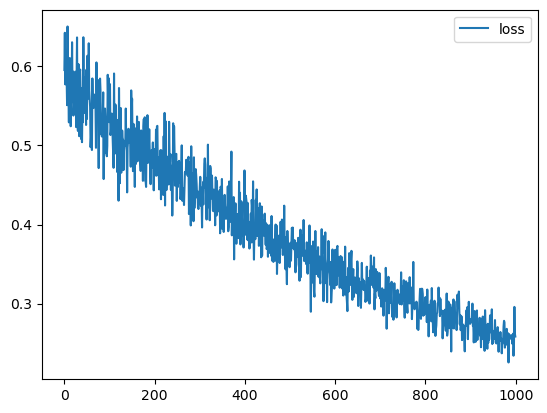

In [105]:
plt.plot(history.history["loss"], label='loss')
plt.legend()
plt.show()

In [119]:
x

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.313131

In [118]:
y_pred = model.predict(x)

TypeError: in user code:

    File "/home/dracdarktime/anaconda3/envs/rn/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/dracdarktime/anaconda3/envs/rn/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dracdarktime/anaconda3/envs/rn/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dracdarktime/anaconda3/envs/rn/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/dracdarktime/anaconda3/envs/rn/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filem1azpkbb.py", line 72, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(filas),), None, fscope), None, loop_body_1, get_state_3, set_state_3, ('base',), {'iterate_names': 'i'})

    TypeError: Exception encountered when calling layer 'polonomio_grado3_9' (type Polonomio_grado3).
    
    in user code:
    
        File "/tmp/ipykernel_34709/2047119550.py", line 43, in call  *
            for i in range(filas):
    
        TypeError: 'NoneType' object cannot be interpreted as an integer
    
    
    Call arguments received by layer 'polonomio_grado3_9' (type Polonomio_grado3):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)


graficamos la funcion

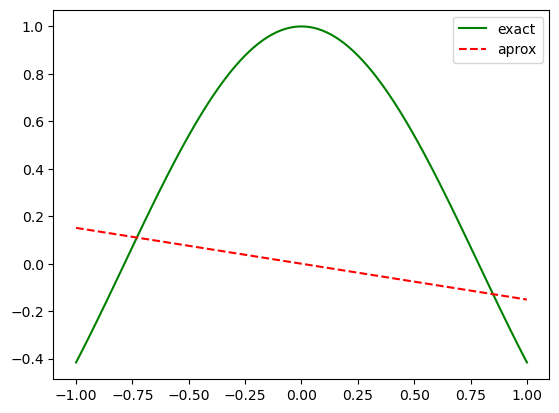

In [ ]:
plt.plot(x,tf.math.cos(2.*x) , label="exact", color='green')
plt.plot(x,y_pred,label="aprox", color='red', linestyle='--')
plt.legend()
plt.show()